In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utilities.controllers import LQRController, TVLQRController
from utilities.prepareTrajectory import prepare_trajectory
from utilities.plant import PendulumPlant_, PendulumPlantApprox
from utilities.plot import quad_form,get_ellipse_patch, plotFunnel, plotFunnel3d, sample_from_ellipsoid, \
                            plotFunnel_fromCsv, ellipseComparison, funnel2DComparison
from utilities.simulation import Simulator
from utilities.process_data import saveFunnel, saveFunnel_probabilistic
from timeInvSOS.TI_SOSroa import SOSequalityConstrained
from nominalTrajectory.directCollocation import DirectCollocationCalculator
from SosBilinearAlternation import TVmultSearch, TVrhoSearch
from samplingMethod.probabilistic import TVprobRhoComputation

#os.environ["MOSEKLM_LICENSE_FILE"] = "/home/federico/mosek/mosek.lic"

# Parameters initialization

In [2]:
# pendulum parameters
mass = 0.57288
length = 0.5
damping = 0.15
gravity = 9.81
coulomb_fric = 0.0
torque_limit = 2 #1.5
inertia = mass*length*length

# swingup parameters
x0 = [0.0, 0.0]
goal = [np.pi, 0.0]

# direct collocation parameters, N is chosen also to be the number of knot points
N = 60
max_dt = 0.05

# do you want to verify the SOS funnel? the procedure takes time
verify = False

# Compute the nominal trajectory via direct collocation

In [3]:
log_dir = "nominalTrajectory/log_data"
csv_path = os.path.join(log_dir, f"trajectory{max_dt}-{N}.csv")
#if not os.path.exists(csv_path):
dircal = DirectCollocationCalculator()
dircal.init_pendulum(mass=mass,
                    length=length,
                    damping=damping,
                    gravity=gravity,
                    torque_limit=torque_limit)
x_trajectory, dircol, result = dircal.compute_trajectory(N=N,
                                                        max_dt=max_dt,
                                                        start_state=x0,
                                                        goal_state=goal)
T, X, XD, U = dircal.extract_trajectory(x_trajectory, dircol, result, N=N)

# save results
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

csv_data = np.vstack((T, X, XD, U)).T
np.savetxt(csv_path, csv_data, delimiter=',',
        header="time,pos,vel,torque", comments="")

# Funnel Computation

In [4]:
def TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof, phi_t, rho_init):

    # Initial rho(t) definition (exponential init)
    # c = 2
    # rho_t = 1.33*np.exp(c*(time-time[-1])/time[-1])
    rho_t = rho_init
    cost_prev = np.inf
    
    # Bilinear SOS alternation for improving the first guess
    convergence = False
    while(not convergence):
        h_maps = []
        gamma_min = 0
        for knot in np.flip([i for i in range(1,round(N))]):
            print("---------------")
            print(f"Multiplier step in knot {knot-1}:")

            fail = True
            while(fail):
                # Search for a multiplier, fixing rho
                (fail, h_map, gamma_i) = TVmultSearch(pendulum, controller, knot, time, rho_t, phi_t)
                if fail:
                    rho_t[knot-1] = 0.8*rho_t[knot-1]
            print(f"The feasible rho is {rho_t[knot-1]}")
            h_maps = np.append(h_map, h_maps)
            gamma_min = 0 #min(gamma_min, gamma_i)

        for knot in np.flip([i for i in range(1,round(N))]):
            print("---------------")
            print(f"V step in knot {knot-1}:")

            fail = True
            while(fail):
                # Search for rho, fixing the multiplier       
                (fail, rho_opt) = TVrhoSearch(pendulum, controller, knot, time, h_maps[knot-1], rho_t, phi_t, gamma_min)
                if fail:
                    gamma_min = 0.75*gamma_min
                    # if (round(gamma_min*10e4) == 0):
                    #     fail = False
                else:
                    print("RHO IMPROVES!!")
            rho_t[knot-1] = rho_opt
        
        # Check for convergence
        eps = 0.1
        if((cost_prev - np.sum(rho_t))/cost_prev < eps): 
            convergence = True  
        cost_prev = np.sum(rho_t)
    
    print("---------------")
    print(f"The final rho is: {rho_t}")
    return (rho_t, controller.tvlqr.S)


In [5]:
# def TVSOSphiBiAlternation(pendulum, controller, time, N, rhof):

#     # Initial rho(t) definition (exponential init)
#     c = 2
#     rho_t = 15*np.exp(c*(time-time[-1])/time[-1])
#     rho_t[-1] = rhof
#     cost_prev = np.inf

#     phi_t = np.zeros((N,3)) #1e-10*np.ones((N,3))
    
#     # Bilinear SOS alternation for improving the first guess
#     convergence = False
#     while(not convergence):
#         h_maps = []
#         gamma_min = 0
#         for knot in np.flip([i for i in range(1,round(N))]):
#             print("---------------")
#             print(f"Multiplier step in knot {knot-1}:")

#             fail = True
#             while(fail):
#                 # Search for a multiplier, fixing rho
#                 (fail, h_map, gamma_i) = TVmultSearch(pendulum, controller, knot, time, rho_t, phi_t)
#                 if fail:
#                     rho_t[knot-1] = 0.8*rho_t[knot-1]
#             print(f"The feasible rho is {rho_t[knot-1]}")
#             h_maps = np.append(h_map, h_maps)
#             gamma_min = 0 #min(gamma_min, gamma_i)

#         for knot in np.flip([i for i in range(1,round(N))]):
#             print("---------------")
#             print(f"V step in knot {knot-1}:")

#             fail = True
#             while(fail):
#                 # Search for phi and rho, fixing the multiplier     
#                 (fail, phi_opt) = TVphiSearch_sum(pendulum, controller, knot, time, h_maps[knot-1], rho_t, phi_t, gamma_min)
#                 if fail:
#                     gamma_min = 0.75*gamma_min
#                     # if (round(gamma_min*10e4) == 0):
#                     #     fail = False
#                 else:
#                     print("PHI IMPROVES!!")
#             phi_t[knot-1] = phi_opt
        
#         # Check for convergence
#         eps = 0.1
#         if((cost_prev - np.sum(rho_t))/cost_prev < eps): 
#             convergence = True  
#         cost_prev = np.sum(rho_t)
    
#     print("---------------")
#     print(f"The final phi is: {phi_t}")
#     return (rho_t, phi_t)

phi_t = np.zeros((N,3)) #1e-10*np.ones((N,3))  --- NO S OPTIMIZATION NOW ---

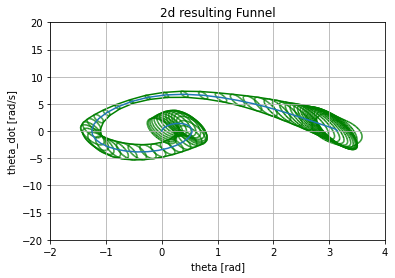

In [6]:
# load results
csv_path = f"nominalTrajectory/log_data/trajectory{max_dt}-{N}.csv"
data_dict = prepare_trajectory(csv_path)
trajectory = np.loadtxt(csv_path, skiprows=1, delimiter=",")
time = trajectory.T[0].T
dt = time[1]-time[0]
x0_traj = [trajectory.T[1].T, trajectory.T[2].T]

# Initializing the pendulum plant
pendulum = PendulumPlant_(mass=mass,
                         length=length,
                         damping=damping,
                         gravity=gravity,
                         coulomb_fric=coulomb_fric,
                         inertia=None,
                         torque_limit=torque_limit)

# Initializing the TVLQR controller
controller = TVLQRController(data_dict=data_dict, mass=mass, length=length,
                             damping=damping, gravity=gravity,
                             torque_limit=torque_limit)
controller.set_goal(goal)

# Taking the final value of rho from the time invariant case, SOS method has been chosen
(rhof, Sf) = SOSequalityConstrained(pendulum,LQRController(mass=mass,
                                                            length=length,
                                                            damping=damping,
                                                            gravity=gravity,
                                                            torque_limit=torque_limit))


csv_pathFunnelSos = f"log_data/sos/funnel{max_dt}-{N}.csv"
if not os.path.exists(csv_pathFunnelSos):
    # Application of the algorithm for time-variand RoA estimation
    # Initial rho(t) definition (exponential init)
    c = 2
    rho_init = 15*np.exp(c*(time-time[-1])/time[-1])
    rho_init[-1] = rhof
    (rho, S) = TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof, phi_t, rho_init)
    saveFunnel(rho, S,time, N, max_dt)
    plotFunnel(rho, S,x0_traj, time, phi_t)
else:
    plotFunnel_fromCsv(csv_pathFunnelSos, x0_traj,time)
    data = np.loadtxt(csv_pathFunnelSos, skiprows=1, delimiter=",")
    rho = data[0].T

In [7]:
print("The final rho is: "+str(rho))

The final rho is: [1.23457952 1.08367789 0.9684971  0.92995189 0.93193203 0.97349985
 1.0513511  1.18031921 1.3056884  1.46390839 1.52468771 1.51620478
 1.34880561 1.07235955 0.75725716 0.54037625 0.40149007 0.32973025
 0.30734619 0.32686324 0.38366847 0.47550442 0.59577236 0.72865266
 0.84871395 0.91991143 0.90308616 0.74110677 0.45921099 0.24904378
 0.12839672 0.06642888 0.03636304 0.0245924  0.03440701 0.05057816
 0.07484643 0.11198072 0.17035506 0.26453366 0.41857433 0.61259147
 0.82731547 1.03979769 1.24769454 1.46235311 1.69878846 1.87346682
 2.02579556 2.15985214 2.27581952 2.37303339 2.44767709 2.48933401
 2.47754385 2.39069978 2.27863419 2.17770793 2.15844176 2.37829223]


# Funnel Verification

In [8]:
if verify:
    pendulum_approx = PendulumPlantApprox(mass=mass,
                                        length=length,
                                        damping=damping,
                                        gravity=gravity,
                                        coulomb_fric=coulomb_fric,
                                        inertia=None,
                                        torque_limit=torque_limit, 
                                        taylorApprox_order = 5, nominal_traj = x_trajectory)

    print("Warning: The verification procedure takes time")
    nSimulations = 50
    tests = [i*5 for i in range(round(N/5))]
    for ver_idx in tests:
        print(f"Verification of the knot {ver_idx}...")
        # figure initialization
        fig = plt.figure(figsize=(18,8))
        fig.suptitle("Verification of RoA guarantee certificate")
        gs = fig.add_gridspec(1, 2)
        ax = fig.add_subplot(gs[0,0])
        ax.set_xlabel("x")
        ax.set_ylabel(r"$\dot{x}$")
    
        dt = 0.005 # simulation time interval

        phi_i = np.array([[phi_t[ver_idx][0], phi_t[ver_idx][1]],[phi_t[ver_idx][1], phi_t[ver_idx][2]]])

        # plot of the verified ellipse
        S_t = controller.tvlqr.S
        p = get_ellipse_patch(np.array(x0_traj).T[ver_idx][0],np.array(x0_traj).T[ver_idx][1],rho[ver_idx],S_t.value(time[ver_idx])+phi_i,linec= "black")
        ax.add_patch(p)
        ax.grid(True)
        plt.title(f"Verified ellipse, knot {ver_idx}...")

        ax2 = fig.add_subplot(gs[0,1], projection='3d') 
        plotFunnel3d(rho, controller.tvlqr.S, x0_traj, time, ax2, phi_t) # 3d funnel plot
        ax2.plot(time, x0_traj[0],x0_traj[1]) # plot the nominal traj

        one_green = False
        one_red = False
        for j in range(1,nSimulations+1):                                                                                                              

            xBar0=sample_from_ellipsoid(S_t.value(time[ver_idx])+phi_i,rho[ver_idx]) # sample new initial state inside the estimated RoA
            x_i=xBar0+np.array(x0_traj).T[ver_idx] 

            sim = Simulator(plant=pendulum_approx) # init the simulation
            
            T, X, U = sim.simulate(time[ver_idx], x_i, time[-1], dt, controller) # simulating this interval 

            # plotting the checked initial states and resulting trajectories, the color depends on the result  
            finalJ = quad_form(S_t.value(time[-1]),X[-1]-np.array(x0_traj).T[-1])
        
            if (finalJ < rho[-1]):
                greenDot = ax.scatter([x_i[0]],[x_i[1]],color="green",marker="o")
                ax2.plot(T, np.array(X).T[0],np.array(X).T[1], color = "green")
                one_green = True
            else:
                redDot = ax.scatter([x_i[0]],[x_i[1]],color="red",marker="o")
                ax2.plot(T, np.array(X).T[0],np.array(X).T[1], color = "red")
                one_red = True

        # managing the dynamic legend of the plot
        if (one_green and one_red):
            ax.legend(handles = [greenDot,redDot,p], 
                        labels = ["successfull initial state","failing initial state", "Initial RoA"])
        elif ((not one_red) and one_green): 
            ax.legend(handles = [greenDot,p], 
                        labels = ["successfull initial state","Initial RoA"])
        else:
            ax.legend(handles = [redDot,p], 
                        labels = ["failing initial state","Initial RoA"])

    plt.show()

# Methods comparison

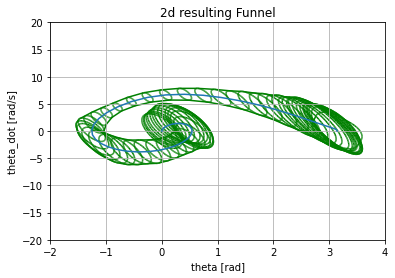

In [9]:
# Estimation via the simulation-based method
csv_pathFunnelProb = f"log_data/probabilistic/funnel{max_dt}-{N}.csv"
if not os.path.exists(csv_pathFunnelProb):
    nSimulations = 100
    (rho_prob, S) = TVprobRhoComputation(pendulum, controller, x0_traj,time, N, nSimulations, rhof)
    saveFunnel_probabilistic(rho_prob, controller.tvlqr.S,time,N, max_dt)
    plotFunnel(rho_prob, controller.tvlqr.S, x0_traj,time, phi_t)
else:
    plotFunnel_fromCsv(csv_pathFunnelProb, x0_traj,time)
    data = np.loadtxt(csv_pathFunnelProb, skiprows=1, delimiter=",")
    rho_prob = data[0].T

In [10]:
print("The final rho is: "+str(rho_prob))

The final rho is: [2.3214827  1.99430737 2.04295989 1.96841809 2.15077537 2.26001762
 2.62012898 3.07892093 3.05798609 3.01594907 2.95054522 2.91825025
 2.65103342 1.91561037 1.21078243 0.83789237 0.74926887 0.66679122
 0.74325266 0.87856816 1.07585051 1.10447492 1.40263544 1.76694171
 2.05774285 1.94556616 1.84727797 1.43553525 0.99916058 0.55884675
 0.33411255 0.19408216 0.13506426 0.14291799 0.17436177 0.21066808
 0.28105162 0.37589395 0.49876578 0.66078809 1.01393148 1.27916443
 1.7555052  2.03047874 2.66631207 2.79028339 3.31982823 3.48948087
 4.14935803 4.10374166 3.77070219 3.51917934 3.28306754 3.48038359
 3.39082025 3.48590145 3.5428527  3.37843551 2.60484386 2.37829223]


In [11]:
if verify:
    pendulum_approx = PendulumPlantApprox(mass=mass,
                                        length=length,
                                        damping=damping,
                                        gravity=gravity,
                                        coulomb_fric=coulomb_fric,
                                        inertia=None,
                                        torque_limit=torque_limit, 
                                        taylorApprox_order = 5, nominal_traj = x_trajectory)

    print("Warning: The verification procedure takes time")
    nSimulations = 50
    tests = [i*5 for i in range(round(N/5))]
    for ver_idx in tests:
        print(f"Verification of the knot {ver_idx}...")
        # figure initialization
        fig = plt.figure(figsize=(18,8))
        fig.suptitle("Verification of RoA guarantee certificate")
        gs = fig.add_gridspec(1, 2)
        ax = fig.add_subplot(gs[0,0])
        ax.set_xlabel("x")
        ax.set_ylabel(r"$\dot{x}$")
    
        dt = 0.005 # simulation time interval

        phi_i = np.array([[phi_t[ver_idx][0], phi_t[ver_idx][1]],[phi_t[ver_idx][1], phi_t[ver_idx][2]]])

        # plot of the verified ellipse
        S_t = controller.tvlqr.S
        p = get_ellipse_patch(np.array(x0_traj).T[ver_idx][0],np.array(x0_traj).T[ver_idx][1],rho_prob[ver_idx],S_t.value(time[ver_idx])+phi_i,linec= "black")
        ax.add_patch(p)
        ax.grid(True)
        plt.title(f"Verified ellipse, knot {ver_idx}...")

        ax2 = fig.add_subplot(gs[0,1], projection='3d') 
        plotFunnel3d(rho_prob, controller.tvlqr.S, x0_traj, time, ax2, phi_t) # 3d funnel plot
        ax2.plot(time, x0_traj[0],x0_traj[1]) # plot the nominal traj

        one_green = False
        one_red = False
        for j in range(1,nSimulations+1):                                                                                                              

            xBar0=sample_from_ellipsoid(S_t.value(time[ver_idx])+phi_i,rho_prob[ver_idx]) # sample new initial state inside the estimated RoA
            x_i=xBar0+np.array(x0_traj).T[ver_idx] 

            sim = Simulator(plant=pendulum_approx) # init the simulation
            
            T, X, U = sim.simulate(time[ver_idx], x_i, time[-1], dt, controller) # simulating this interval 

            # plotting the checked initial states and resulting trajectories, the color depends on the result  
            finalJ = quad_form(S_t.value(time[-1]),X[-1]-np.array(x0_traj).T[-1])
        
            if (finalJ < rho[-1]):
                greenDot = ax.scatter([x_i[0]],[x_i[1]],color="green",marker="o")
                ax2.plot(T, np.array(X).T[0],np.array(X).T[1], color = "green")
                one_green = True
            else:
                redDot = ax.scatter([x_i[0]],[x_i[1]],color="red",marker="o")
                ax2.plot(T, np.array(X).T[0],np.array(X).T[1], color = "red")
                one_red = True

        # managing the dynamic legend of the plot
        if (one_green and one_red):
            ax.legend(handles = [greenDot,redDot,p], 
                        labels = ["successfull initial state","failing initial state", "Initial RoA"])
        elif ((not one_red) and one_green): 
            ax.legend(handles = [greenDot,p], 
                        labels = ["successfull initial state","Initial RoA"])
        else:
            ax.legend(handles = [redDot,p], 
                        labels = ["failing initial state","Initial RoA"])

    plt.show()

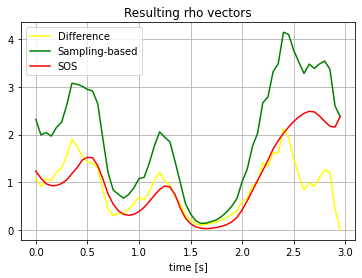

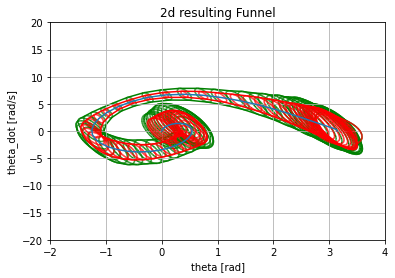

In [12]:
rho_diff = rho_prob - rho
fig, ax = plt.subplots()
plt.title("Resulting rho vectors")
plt.grid(True)
ax.set_xlabel("time [s]")
ax.plot(time,rho_diff, color = "yellow", label = 'Difference')
ax.plot(time, rho_prob, color = "green", label = 'Sampling-based')
ax.plot(time,rho, color = "red", label = 'SOS')
ax.legend()

# comparison = [i*10 for i in range(round(N/10))]
# for compared_knot in comparison:
#     ellipseComparison(csv_pathFunnelSos, csv_pathFunnelProb,x0_traj, compared_knot)

funnel2DComparison(csv_pathFunnelSos, csv_pathFunnelProb,x0_traj,time)

plt.show()